In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score
from scipy.special import expit

from ampligraph.datasets import load_fb13
from ampligraph.latent_features.models import TransE, ComplEx, DistMult

/home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ptabacof/miniconda3/envs/py37/lib/pyt

In [2]:
from generate_corruptions import generate_corruptions, calibration_loss, pos_iso
import types

In [3]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [4]:
X = load_fb13()

In [5]:
X_valid_pos = X['valid'][X['valid_labels']]
X_valid_neg = X['valid'][~X['valid_labels']]

X_test_pos = X['test'][X['test_labels']]
X_test_neg = X['test'][~X['test_labels']]

In [6]:
results = []

for eta in [1, 5, 10, 20, 50, 100]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=100, eta=eta,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'eta': eta,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

WARNING - From /home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabac

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 1,
  "brier_score_scores": 0.4300712133146242,
  "log_loss_scores": 1.4576601095794612,
  "brier_score_probas_pos": 0.18056286487629158,
  "log_loss_probas_pos": 0.5363288433707171,
  "brier_score_probas_pos_neg": 0.161929439582455,
  "log_loss_probas_pos_neg": 0.4889126227686992,
  "brier_score_probas_pos_neg_iso": 0.1613800220246881,
  "log_loss_probas_pos_neg_iso": 0.48657674570982606,
  "brier_score_probas_pos_iso": 0.192083801010497,
  "log_loss_probas_pos_iso": 0.560877321775098,
  "brier_score_probas_pos_sc": 0.1884590659669862,
  "log_loss_probas_pos_sc": 0.5539342561793897,
  "brier_score_probas_pos_neg_sc": 0.16192937153395157,
  "log_loss_probas_pos_neg_sc": 0.4889159659527209,
  "ece_scores": 0.45054085841272123,
  "ece_probas_pos": 0.11730436693651566,
  "ece_probas_pos_neg": 0.022089915916125222,
  "ece_probas_pos_neg_iso": 0.00684657903374208,
  "ece_probas_pos_iso": 0.14791742602230779,
  "ece_probas_pos_sc": 0.14257758654888075,
  "ece_probas_pos_neg_sc": 0.

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 5,
  "brier_score_scores": 0.4433524993527382,
  "log_loss_scores": 1.5228398653124793,
  "brier_score_probas_pos": 0.15193741133035146,
  "log_loss_probas_pos": 0.46942517567470426,
  "brier_score_probas_pos_neg": 0.13323532576962488,
  "log_loss_probas_pos_neg": 0.414833292554373,
  "brier_score_probas_pos_neg_iso": 0.1333680603766317,
  "log_loss_probas_pos_neg_iso": 0.4145211751120904,
  "brier_score_probas_pos_iso": 0.1539421906528174,
  "log_loss_probas_pos_iso": 0.47233264356404925,
  "brier_score_probas_pos_sc": 0.15668122606880905,
  "log_loss_probas_pos_sc": 0.4789203979999876,
  "brier_score_probas_pos_neg_sc": 0.13323535595005173,
  "log_loss_probas_pos_neg_sc": 0.41483444873631653,
  "ece_scores": 0.460594735719413,
  "ece_probas_pos": 0.10565291892893496,
  "ece_probas_pos_neg": 0.015233341244688413,
  "ece_probas_pos_neg_iso": 0.007225436504274091,
  "ece_probas_pos_iso": 0.09998585899132441,
  "ece_probas_pos_sc": 0.12012816520169836,
  "ece_probas_pos_neg_sc

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 10,
  "brier_score_scores": 0.44494654121756977,
  "log_loss_scores": 1.5308721464066357,
  "brier_score_probas_pos": 0.1475773101243118,
  "log_loss_probas_pos": 0.4591472092899204,
  "brier_score_probas_pos_neg": 0.12897552745969756,
  "log_loss_probas_pos_neg": 0.4032743165161362,
  "brier_score_probas_pos_neg_iso": 0.12903559890662122,
  "log_loss_probas_pos_neg_iso": 0.4033371740420748,
  "brier_score_probas_pos_iso": 0.14793637210946822,
  "log_loss_probas_pos_iso": 0.4586170089186479,
  "brier_score_probas_pos_sc": 0.15133788697423717,
  "log_loss_probas_pos_sc": 0.4659660198052232,
  "brier_score_probas_pos_neg_sc": 0.12897563101827628,
  "log_loss_probas_pos_neg_sc": 0.40327498774458637,
  "ece_scores": 0.4617727734820348,
  "ece_probas_pos": 0.109165309955514,
  "ece_probas_pos_neg": 0.011441448577515645,
  "ece_probas_pos_neg_iso": 0.009431728082133564,
  "ece_probas_pos_iso": 0.09403639622862332,
  "ece_probas_pos_sc": 0.11824915488113179,
  "ece_probas_pos_neg_s

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 20,
  "brier_score_scores": 0.44570744612730917,
  "log_loss_scores": 1.5341358116820145,
  "brier_score_probas_pos": 0.14400251565892225,
  "log_loss_probas_pos": 0.45091790717050334,
  "brier_score_probas_pos_neg": 0.1256580246611125,
  "log_loss_probas_pos_neg": 0.3945443392365233,
  "brier_score_probas_pos_neg_iso": 0.1259622368031616,
  "log_loss_probas_pos_neg_iso": 0.3952111820733949,
  "brier_score_probas_pos_iso": 0.14338596898421369,
  "log_loss_probas_pos_iso": 0.4481469581895585,
  "brier_score_probas_pos_sc": 0.1471024206536069,
  "log_loss_probas_pos_sc": 0.4560191702539379,
  "brier_score_probas_pos_neg_sc": 0.12565821743952169,
  "log_loss_probas_pos_neg_sc": 0.39454597800732705,
  "ece_scores": 0.4624151334118807,
  "ece_probas_pos": 0.10855369529293336,
  "ece_probas_pos_neg": 0.010706406629810887,
  "ece_probas_pos_neg_iso": 0.010711507258231615,
  "ece_probas_pos_iso": 0.09507827369594136,
  "ece_probas_pos_sc": 0.1145406778182928,
  "ece_probas_pos_neg_s

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 50,
  "brier_score_scores": 0.44594988182064393,
  "log_loss_scores": 1.533718437011895,
  "brier_score_probas_pos": 0.14220094375223463,
  "log_loss_probas_pos": 0.4465992523625656,
  "brier_score_probas_pos_neg": 0.12432885450510185,
  "log_loss_probas_pos_neg": 0.3908717654236316,
  "brier_score_probas_pos_neg_iso": 0.12462165266605149,
  "log_loss_probas_pos_neg_iso": 0.3909809567243799,
  "brier_score_probas_pos_iso": 0.14141254546463397,
  "log_loss_probas_pos_iso": 0.443358121160162,
  "brier_score_probas_pos_sc": 0.1450934073667903,
  "log_loss_probas_pos_sc": 0.45119408870379846,
  "brier_score_probas_pos_neg_sc": 0.12432903832657466,
  "log_loss_probas_pos_neg_sc": 0.3908832488124045,
  "ece_scores": 0.4625985663897188,
  "ece_probas_pos": 0.10829088447991299,
  "ece_probas_pos_neg": 0.0088558978221076,
  "ece_probas_pos_neg_iso": 0.007782983445147986,
  "ece_probas_pos_iso": 0.09037485651195686,
  "ece_probas_pos_sc": 0.11176565866522313,
  "ece_probas_pos_neg_sc"

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


In [7]:
eta_results = results

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
df=pd.DataFrame(eta_results)
df.columns

Index(['eta', 'brier_score_scores', 'log_loss_scores',
       'brier_score_probas_pos', 'log_loss_probas_pos',
       'brier_score_probas_pos_neg', 'log_loss_probas_pos_neg',
       'brier_score_probas_pos_neg_iso', 'log_loss_probas_pos_neg_iso',
       'brier_score_probas_pos_iso', 'log_loss_probas_pos_iso',
       'brier_score_probas_pos_sc', 'log_loss_probas_pos_sc',
       'brier_score_probas_pos_neg_sc', 'log_loss_probas_pos_neg_sc',
       'ece_scores', 'ece_probas_pos', 'ece_probas_pos_neg',
       'ece_probas_pos_neg_iso', 'ece_probas_pos_iso', 'ece_probas_pos_sc',
       'ece_probas_pos_neg_sc', 'metrics_mrr', 'metrics_hits@10', 'metrics_mr',
       'accuracy_per_relation', 'accuracy_uncalib', 'accuracy_pos',
       'accuracy_pos_neg', 'accuracy_pos_neg_iso', 'accuracy_pos_iso',
       'accuracy_pos_sc', 'accuracy_pos_neg_sc'],
      dtype='object')

In [59]:
df.to_csv("fb13_eta.csv", index=False)

Text(0.5, 1.0, 'FB13')

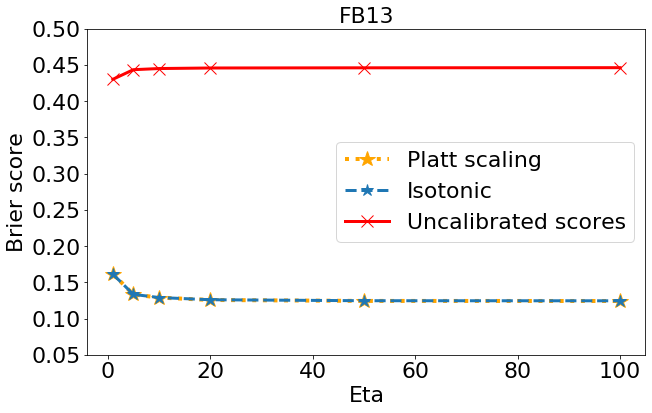

In [60]:
plt.rcParams.update({'font.size': 22, 'axes.titlesize': 22})

fig, ax1 = plt.subplots(figsize=(10, 6))

ln1 = ax1.plot(df.eta, df.brier_score_probas_pos_neg, "*:", lw=4, label="Platt scaling", color='orange', fillstyle='full',  markersize=16)
ln2 = ax1.plot(df.eta, df.brier_score_probas_pos_neg_iso, "*--", lw=3, label="Isotonic", color='tab:blue', fillstyle='full', markersize=12)
ln3 = ax1.plot(df.eta, df.brier_score_scores, "x-", lw=3, label="Uncalibrated scores", color='r', fillstyle='full',  markersize=12)
ax1.set_yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Eta")
plt.ylabel("Brier score")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ln4 = ax2.plot(df.eta, df.metrics_mrr, "o--", lw=3, label="MRR", color='black', fillstyle='full', markersize=12)
# ax2.set_yticks([0.15, 0.2, 0.25, 0.3, 0.35])

# lns = ln1+ln2+ln3+ln4
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=0)

# plt.ylabel("MRR")
ax1.legend()

plt.title("FB13")

In [12]:
results = []

for k in [10, 25, 50, 100, 200, 500]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=k, eta=20,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'k': k,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

pos [-1.0852752, -3.7059863]
pos neg [-1.5415161, -4.5254216]
pos sc -1.1329830199312005 -3.9444785249326793
pos neg sc -1.5411924757920834 -4.5243753095025125


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 10,
  "brier_score_scores": 0.4339756585043363,
  "log_loss_scores": 1.3973785771526064,
  "brier_score_probas_pos": 0.22097238439538425,
  "log_loss_probas_pos": 0.6317446012112573,
  "brier_score_probas_pos_neg": 0.2053520346809688,
  "log_loss_probas_pos_neg": 0.5945740012092431,
  "brier_score_probas_pos_neg_iso": 0.2045821256748386,
  "log_loss_probas_pos_neg_iso": 0.5924690806777612,
  "brier_score_probas_pos_iso": 0.23564103766038216,
  "log_loss_probas_pos_iso": 0.6623289942710608,
  "brier_score_probas_pos_sc": 0.22554377271593493,
  "log_loss_probas_pos_sc": 0.642369359482893,
  "brier_score_probas_pos_neg_sc": 0.2053523007306928,
  "log_loss_probas_pos_neg_sc": 0.5945745035564898,
  "ece_scores": 0.44176956867058564,
  "ece_probas_pos": 0.11319574187783636,
  "ece_probas_pos_neg": 0.028297227891323693,
  "ece_probas_pos_neg_iso": 0.007373025518510036,
  "ece_probas_pos_iso": 0.14232716900872328,
  "ece_probas_pos_sc": 0.13299761797447487,
  "ece_probas_pos_neg_sc": 

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 25,
  "brier_score_scores": 0.44270985480564684,
  "log_loss_scores": 1.4995092348412915,
  "brier_score_probas_pos": 0.17506134187571934,
  "log_loss_probas_pos": 0.5252027053520084,
  "brier_score_probas_pos_neg": 0.1573011461062912,
  "log_loss_probas_pos_neg": 0.4808963955293496,
  "brier_score_probas_pos_neg_iso": 0.15758475811173356,
  "log_loss_probas_pos_neg_iso": 0.48194849699308456,
  "brier_score_probas_pos_iso": 0.1840476720432383,
  "log_loss_probas_pos_iso": 0.5464983208611875,
  "brier_score_probas_pos_sc": 0.1810534551832893,
  "log_loss_probas_pos_sc": 0.5382186744361365,
  "brier_score_probas_pos_neg_sc": 0.1573011547151355,
  "log_loss_probas_pos_neg_sc": 0.48089535196081024,
  "ece_scores": 0.4573182893677423,
  "ece_probas_pos": 0.10513357944961105,
  "ece_probas_pos_neg": 0.010172020458721006,
  "ece_probas_pos_neg_iso": 0.007588049701805528,
  "ece_probas_pos_iso": 0.1202242152788099,
  "ece_probas_pos_sc": 0.1231756625152718,
  "ece_probas_pos_neg_sc": 

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 50,
  "brier_score_scores": 0.44521173340117065,
  "log_loss_scores": 1.5282026930835186,
  "brier_score_probas_pos": 0.1524322887501081,
  "log_loss_probas_pos": 0.4708372326137955,
  "brier_score_probas_pos_neg": 0.1341320024470034,
  "log_loss_probas_pos_neg": 0.4179116738026824,
  "brier_score_probas_pos_neg_iso": 0.1343559337423274,
  "log_loss_probas_pos_neg_iso": 0.41759563139673217,
  "brier_score_probas_pos_iso": 0.1549152323305005,
  "log_loss_probas_pos_iso": 0.47585253926343224,
  "brier_score_probas_pos_sc": 0.15693159283446703,
  "log_loss_probas_pos_sc": 0.47965326297598176,
  "brier_score_probas_pos_neg_sc": 0.13413205681191714,
  "log_loss_probas_pos_neg_sc": 0.41791309945796745,
  "ece_scores": 0.46142518667031074,
  "ece_probas_pos": 0.10566689918681377,
  "ece_probas_pos_neg": 0.015061331381991507,
  "ece_probas_pos_neg_iso": 0.010031875123905932,
  "ece_probas_pos_iso": 0.10292697610442998,
  "ece_probas_pos_sc": 0.1180684624671641,
  "ece_probas_pos_neg_s

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 100,
  "brier_score_scores": 0.4456995846446613,
  "log_loss_scores": 1.5344794664697163,
  "brier_score_probas_pos": 0.14464636995726046,
  "log_loss_probas_pos": 0.45230694370655883,
  "brier_score_probas_pos_neg": 0.12632943068138008,
  "log_loss_probas_pos_neg": 0.39613007124998995,
  "brier_score_probas_pos_neg_iso": 0.12662109286385984,
  "log_loss_probas_pos_neg_iso": 0.39630189252356357,
  "brier_score_probas_pos_iso": 0.1442834852799898,
  "log_loss_probas_pos_iso": 0.44989051269502967,
  "brier_score_probas_pos_sc": 0.14774653125349943,
  "log_loss_probas_pos_sc": 0.4573720173230707,
  "brier_score_probas_pos_neg_sc": 0.12632963246660892,
  "log_loss_probas_pos_neg_sc": 0.3961297772937017,
  "ece_scores": 0.46237430167342847,
  "ece_probas_pos": 0.1080223146506431,
  "ece_probas_pos_neg": 0.01096687143294621,
  "ece_probas_pos_neg_iso": 0.00966530220033459,
  "ece_probas_pos_iso": 0.09678476398206488,
  "ece_probas_pos_sc": 0.11485311084990493,
  "ece_probas_pos_neg_

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 200,
  "brier_score_scores": 0.44559106265691895,
  "log_loss_scores": 1.5320862182830934,
  "brier_score_probas_pos": 0.1384974732854741,
  "log_loss_probas_pos": 0.4376367476127243,
  "brier_score_probas_pos_neg": 0.12010669706419276,
  "log_loss_probas_pos_neg": 0.3791849871368468,
  "brier_score_probas_pos_neg_iso": 0.12032022125040652,
  "log_loss_probas_pos_neg_iso": 0.37899056566557127,
  "brier_score_probas_pos_iso": 0.13638501910881504,
  "log_loss_probas_pos_iso": 0.4318911021490722,
  "brier_score_probas_pos_sc": 0.14097953365705798,
  "log_loss_probas_pos_sc": 0.4409686819817666,
  "brier_score_probas_pos_neg_sc": 0.1201071084286591,
  "log_loss_probas_pos_neg_sc": 0.37918693270308834,
  "ece_scores": 0.4626529936181259,
  "ece_probas_pos": 0.10969377395858777,
  "ece_probas_pos_neg": 0.00893267206050244,
  "ece_probas_pos_neg_iso": 0.007554582429922189,
  "ece_probas_pos_iso": 0.09288368890850245,
  "ece_probas_pos_sc": 0.11201571464662889,
  "ece_probas_pos_neg_s

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


In [13]:
k_results = results

In [52]:
df=pd.DataFrame(k_results)
df.columns

Index(['k', 'brier_score_scores', 'log_loss_scores', 'brier_score_probas_pos',
       'log_loss_probas_pos', 'brier_score_probas_pos_neg',
       'log_loss_probas_pos_neg', 'brier_score_probas_pos_neg_iso',
       'log_loss_probas_pos_neg_iso', 'brier_score_probas_pos_iso',
       'log_loss_probas_pos_iso', 'brier_score_probas_pos_sc',
       'log_loss_probas_pos_sc', 'brier_score_probas_pos_neg_sc',
       'log_loss_probas_pos_neg_sc', 'ece_scores', 'ece_probas_pos',
       'ece_probas_pos_neg', 'ece_probas_pos_neg_iso', 'ece_probas_pos_iso',
       'ece_probas_pos_sc', 'ece_probas_pos_neg_sc', 'metrics_mrr',
       'metrics_hits@10', 'metrics_mr', 'accuracy_per_relation',
       'accuracy_uncalib', 'accuracy_pos', 'accuracy_pos_neg',
       'accuracy_pos_neg_iso', 'accuracy_pos_iso', 'accuracy_pos_sc',
       'accuracy_pos_neg_sc'],
      dtype='object')

In [53]:
df.to_csv("fb13_k.csv", index=False)

Text(0.5, 1.0, 'FB13')

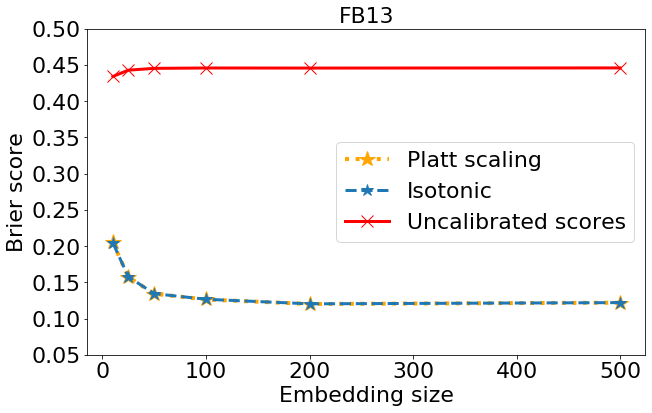

In [57]:
plt.rcParams.update({'font.size': 22, 'axes.titlesize': 22})

fig, ax1 = plt.subplots(figsize=(10, 6))

ln1 = ax1.plot(df.k, df.brier_score_probas_pos_neg, "*:", lw=4, label="Platt scaling", color='orange', fillstyle='full',  markersize=16)
ln2 = ax1.plot(df.k, df.brier_score_probas_pos_neg_iso, "*--", lw=3, label="Isotonic", color='tab:blue', fillstyle='full', markersize=12)
ln3 = ax1.plot(df.k, df.brier_score_scores, "x-", lw=3, label="Uncalibrated scores", color='r', fillstyle='full',  markersize=12)
ax1.set_yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Embedding size")
plt.ylabel("Brier score")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ln4 = ax2.plot(df.k, df.metrics_mrr, "o--", lw=3, label="MRR", color='black', fillstyle='full', markersize=12)
# ax2.set_yticks([0.15, 0.2, 0.25, 0.3, 0.35])

# lns = ln1+ln2+ln3+ln4
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=0)

# plt.ylabel("MRR")
ax1.legend()

plt.title("FB13")